# Description

Generates the figure for top cell types for a specified LV (in Settings section below).

# Modules loading

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from data.recount2 import LVAnalysis
from utils import chunker
import conf

# Settings

In [3]:
LV_NAME = "LV57"

In [4]:
LV_AXIS_THRESHOLD = 3.0
N_TOP_SAMPLES = 400
N_TOP_ATTRS = 25

In [5]:
OUTPUT_FIGURES_DIR = Path(
    conf.MANUSCRIPT["FIGURES_DIR"], "lvs_analysis", f"{LV_NAME.lower()}"
).resolve()
display(OUTPUT_FIGURES_DIR)
OUTPUT_FIGURES_DIR.mkdir(parents=True, exist_ok=True)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier_manuscript/content/images/lvs_analysis/lv57')

In [6]:
OUTPUT_CELL_TYPE_FILEPATH = OUTPUT_FIGURES_DIR / f"{LV_NAME.lower()}-cell_types.svg"
display(OUTPUT_CELL_TYPE_FILEPATH)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier_manuscript/content/images/lvs_analysis/lv57/lv57-cell_types.svg')

# Load MultiPLIER summary

In [7]:
multiplier_model_summary = pd.read_pickle(conf.MULTIPLIER["MODEL_SUMMARY_FILE"])

In [8]:
multiplier_model_summary.shape

(2157, 5)

In [9]:
multiplier_model_summary.head()

,pathway,LV index,AUC,p-value,FDR
1,KEGG_LYSINE_DEGRADATION,1,0.388059,0.866078,0.956005
2,REACTOME_MRNA_SPLICING,1,0.733057,0.000048,0.000582
3,MIPS_NOP56P_ASSOCIATED_PRE_RRNA_COMPLEX,1,0.680555,0.001628,0.011366
4,KEGG_DNA_REPLICATION,1,0.549473,0.312155,0.539951
5,PID_MYC_ACTIVPATHWAY,1,0.639303,0.021702,0.083739


# Load data

## Original data

In [10]:
INPUT_SUBSET = "z_score_std"

In [11]:
INPUT_STEM = "projection-smultixcan-efo_partial-mashr-zscores"

In [12]:
input_filepath = Path(
    conf.RESULTS["DATA_TRANSFORMATIONS_DIR"],
    INPUT_SUBSET,
    f"{INPUT_SUBSET}-{INPUT_STEM}.pkl",
).resolve()
display(input_filepath)

assert input_filepath.exists(), "Input file does not exist"

input_filepath_stem = input_filepath.stem
display(input_filepath_stem)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/bases_data/base_orig/results/data_transformations/z_score_std/z_score_std-projection-smultixcan-efo_partial-mashr-zscores.pkl')

'z_score_std-projection-smultixcan-efo_partial-mashr-zscores'

In [13]:
data = pd.read_pickle(input_filepath)

In [14]:
data.shape

(3752, 987)

In [15]:
data.head()

,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,LV10,...,LV978,LV979,LV980,LV981,LV982,LV983,LV984,LV985,LV986,LV987
100001_raw-Food_weight,-0.695006,1.962565,0.057683,0.878731,-0.539977,1.481272,-0.396422,1.090180,0.759223,0.931395,...,1.129784,1.752343,-1.411403,2.823863,0.931116,-1.054519,0.432982,-0.633597,0.554279,-0.642479
100002_raw-Energy,-1.528127,-0.345309,-0.148953,-0.242060,0.373427,0.791092,0.263477,0.987702,0.354391,1.416059,...,0.224604,0.769882,-0.509482,0.091153,2.286789,-1.008256,-0.029764,1.737229,-0.272107,-0.526125
100003_raw-Protein,-0.704572,-1.011299,0.671420,0.143991,0.615212,0.874212,-0.040998,0.915170,0.254369,-0.084237,...,1.003019,1.044314,-2.376108,0.004778,0.053714,-0.892447,-0.183800,1.377991,-0.278794,-0.419733
100004_raw-Fat,-0.989832,-1.875490,0.261555,-1.420719,0.366238,1.167049,0.257387,0.717674,-0.997664,0.969825,...,0.585913,0.638314,0.119139,-0.140204,1.394326,-1.173402,0.555058,1.013982,-0.544506,-0.064061
100005_raw-Carbohydrate,-0.580143,0.243335,0.158966,-0.036558,0.068176,-0.202639,1.101281,0.675227,1.463432,1.010078,...,-0.249108,-0.026814,0.232713,0.323682,1.168642,-0.282935,0.653105,1.909526,0.199997,-1.656894


## LV data

In [16]:
lv_obj = LVAnalysis(LV_NAME, data)

In [17]:
multiplier_model_summary[
    multiplier_model_summary["LV index"].isin((LV_NAME[2:],))
    & (
        (multiplier_model_summary["FDR"] < 0.05)
        | (multiplier_model_summary["AUC"] >= 0.75)
    )
]

[2021-08-02 15:43:15,675 - numexpr.utils] INFO: NumExpr defaulting to 8 threads.


,pathway,LV index,AUC,p-value,FDR
278,IRIS_CD4Tcell-Th2-restimulated12hour,57,0.778650,0.000975,0.007566
279,IRIS_MemoryTcell-RO-activated,57,0.701502,0.005515,0.028732
280,Custom_Treg,57,0.983002,0.002075,0.013688
281,SVM T cells CD4 memory activated,57,0.790189,0.000279,0.002595
283,PID_NFAT_TFPATHWAY,57,0.737239,0.002393,0.015224
284,KEGG_AUTOIMMUNE_THYROID_DISEASE,57,0.777134,0.022010,0.084325
285,KEGG_ALLOGRAFT_REJECTION,57,0.998664,0.001539,0.010914
287,KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY,57,0.695970,0.000117,0.001260


In [18]:
lv_data = lv_obj.get_experiments_data()

SRP061881, SRP056049, SRP049462, SRP059057, SRP037735, SRP053186, SRP045052, SRP060416, SRP061932, SRP042161, SRP033466, SRP055474, SRP055569, SRP057852, SRP014213, SRP057196, SRP007947, SRP063840, SRP039591, SRP043339, SRP051368, SRP045570, SRP056733, SRP049648, SRP041826, SRP058667, SRP002184, SRP018853, SRP003901, SRP051736, SRP011054, SRP016003, SRP000599, SRP045352, SRP053004, SRP066834, SRP044286, SRP009247, SRP033135, SRP055675, SRP064259, SRP032775, SRP033248, SRP008145, SRP030041, SRP002326, SRP045565, SRP049238, SRP052740, SRP051369, SRP007596, SRP022052, SRP059170, SRP058773, SRP018838, SRP043960, 

In [19]:
lv_data.shape

(5574, 87)

In [20]:
lv_data.head()

diagnosis            tissue            cell type  \
project   run                                                                  
SRP061881 SRR2138065  Healthy control  Peripheral Blood  CD4+CD45RO+ T cells   
          SRR2138066  Healthy control  Peripheral Blood  CD4+CD45RO+ T cells   
          SRR2138067  Healthy control  Peripheral Blood  CD4+CD45RO+ T cells   
          SRR2138068  Healthy control  Peripheral Blood  CD4+CD45RO+ T cells   
          SRR2138077      JIA patient    Synovial Fluid  CD4+CD45RO+ T cells   

                     treatment cell population activation passages bardcode  \
project   run                                                                 
SRP061881 SRR2138065    JQ1(-)             NaN        NaN      NaN      NaN   
          SRR2138066    JQ1(-)             NaN        NaN      NaN      NaN   
          SRR2138067    JQ1(-)             NaN        NaN      NaN      NaN   
          SRR2138068    JQ1(-)             NaN        NaN      NaN      NaN   
          SRR2138077    JQ1(+)             NaN        NaN      NaN      NaN   

                     cell stimulation phenotype  ... mapki treatment  \
project   run                                    ...                   
SRP061881 SRR2138065              NaN       NaN  ...             NaN   
          SRR2138066              NaN       NaN  ...             NaN   
          SRR2138067              NaN       NaN  ...             NaN   
          SRR2138068              NaN       NaN  ...             NaN   
          SRR2138077              NaN       NaN  ...             NaN   

                     cell-type cohort age (yrs) gender well number  \
project   run                                                        
SRP061881 SRR2138065       NaN    NaN       NaN    NaN         NaN   
          SRR2138066       NaN    NaN       NaN    NaN         NaN   
          SRR2138067       NaN    NaN       NaN    NaN         NaN   
          SRR2138068       NaN    NaN       NaN    NaN         NaN   
          SRR2138077       NaN    NaN       NaN    NaN         NaN   

                     reprogramming time point (day) labexpid induction  \
project   run                                                            
SRP061881 SRR2138065                            NaN      NaN       NaN   
          SRR2138066                            NaN      NaN       NaN   
          SRR2138067                            NaN      NaN       NaN   
          SRR2138068                            NaN      NaN       NaN   
          SRR2138077                            NaN      NaN       NaN   

                          LV57  
project   run                   
SRP061881 SRR2138065  1.871110  
          SRR2138066  1.792880  
          SRR2138067  1.880802  
          SRR2138068  1.868914  
          SRR2138077  1.733196  

[5 rows x 87 columns]

# LV cell types analysis

## Get top attributes

In [21]:
lv_attrs = lv_obj.get_attributes_variation_score()
display(lv_attrs.head(20))

diagnosis                        1.101964
treatment                        1.060100
cell population                  0.258077
tissue                           0.148264
cell type                        0.063179
bardcode                         0.058719
passages                         0.049729
activation                       0.033816
genotype                         0.027605
cell stimulation                 0.027167
phenotype                        0.027167
culture condition                0.021831
lab data id                      0.010650
ectopic expression               0.009645
p/i stimulation                  0.009645
polarizing conditions            0.009168
rna fraction                     0.009168
collection site and cell type    0.006223
bacterial community type         0.006223
karyotype                        0.005849
dtype: float64

In [22]:
# show those with cell type or tissue in their name
_tmp = pd.Series(lv_attrs.index)
lv_attrs[
    _tmp.str.match(
        "(?:cell.+type$)|(?:tissue$)|(?:tissue.+type$)",
        case=False,
        flags=re.IGNORECASE,
    ).values
].sort_values(ascending=False)

tissue            0.148264
cell type         0.063179
tissue subtype    0.003338
tissue type       0.002110
cell-type         0.000651
dtype: float64

In [23]:
_tmp = lv_data.loc[
    :,
    [
        "cell type",
        "cell-type",
        "tissue",
        "tissue type",
        "tissue subtype",
        LV_NAME,
    ],
]

In [24]:
_tmp_seq = list(chunker(_tmp.sort_values(LV_NAME, ascending=False), 25))

In [25]:
_tmp_seq[0]

cell type cell-type            tissue  \
project   run                                                           
SRP061881 SRR2138082  CD4+CD45RO+ T cells       NaN    Synovial Fluid   
          SRR2138084  CD4+CD45RO+ T cells       NaN    Synovial Fluid   
          SRR2138081  CD4+CD45RO+ T cells       NaN    Synovial Fluid   
          SRR2138083  CD4+CD45RO+ T cells       NaN    Synovial Fluid   
          SRR2138052  CD4+CD45RO+ T cells       NaN  Peripheral Blood   
          SRR2138050  CD4+CD45RO+ T cells       NaN  Peripheral Blood   
          SRR2138051  CD4+CD45RO+ T cells       NaN  Peripheral Blood   
          SRR2138049  CD4+CD45RO+ T cells       NaN  Peripheral Blood   
          SRR2138076  CD4+CD45RO+ T cells       NaN    Synovial Fluid   
          SRR2138073  CD4+CD45RO+ T cells       NaN    Synovial Fluid   
          SRR2138074  CD4+CD45RO+ T cells       NaN    Synovial Fluid   
          SRR2138075  CD4+CD45RO+ T cells       NaN    Synovial Fluid   
          SRR2138092  CD4+CD45RO+ T cells       NaN    Synovial Fluid   
          SRR2138089  CD4+CD45RO+ T cells       NaN    Synovial Fluid   
          SRR2138091  CD4+CD45RO+ T cells       NaN    Synovial Fluid   
          SRR2138090  CD4+CD45RO+ T cells       NaN    Synovial Fluid   
          SRR2138041  CD4+CD45RO+ T cells       NaN  Peripheral Blood   
          SRR2138042  CD4+CD45RO+ T cells       NaN  Peripheral Blood   
          SRR2138044  CD4+CD45RO+ T cells       NaN  Peripheral Blood   
          SRR2138043  CD4+CD45RO+ T cells       NaN  Peripheral Blood   
          SRR2138059  CD4+CD45RO+ T cells       NaN  Peripheral Blood   
          SRR2138058  CD4+CD45RO+ T cells       NaN  Peripheral Blood   
          SRR2138057  CD4+CD45RO+ T cells       NaN  Peripheral Blood   
          SRR2138060  CD4+CD45RO+ T cells       NaN  Peripheral Blood   
          SRR2138067  CD4+CD45RO+ T cells       NaN  Peripheral Blood   

                     tissue type tissue subtype      LV57  
project   run                                              
SRP061881 SRR2138082         NaN            NaN  3.237987  
          SRR2138084         NaN            NaN  3.232405  
          SRR2138081         NaN            NaN  3.215906  
          SRR2138083         NaN            NaN  3.198581  
          SRR2138052         NaN            NaN  2.897797  
          SRR2138050         NaN            NaN  2.882520  
          SRR2138051         NaN            NaN  2.842245  
          SRR2138049         NaN            NaN  2.822297  
          SRR2138076         NaN            NaN  2.691617  
          SRR2138073         NaN            NaN  2.680197  
          SRR2138074         NaN            NaN  2.671753  
          SRR2138075         NaN            NaN  2.617968  
          SRR2138092         NaN            NaN  2.433035  
          SRR2138089         NaN            NaN  2.428284  
          SRR2138091         NaN            NaN  2.417892  
          SRR2138090         NaN            NaN  2.409283  
          SRR2138041         NaN            NaN  2.040126  
          SRR2138042         NaN            NaN  2.027355  
          SRR2138044         NaN            NaN  2.026000  
          SRR2138043         NaN            NaN  2.002652  
          SRR2138059         NaN            NaN  1.928286  
          SRR2138058         NaN            NaN  1.901997  
          SRR2138057         NaN            NaN  1.885720  
          SRR2138060         NaN            NaN  1.884543  
          SRR2138067         NaN            NaN  1.880802

In [26]:
# what is there in these projects?
lv_data.loc[["SRP053186"]].dropna(how="all", axis=1).sort_values(
    LV_NAME, ascending=False
).sort_values(LV_NAME, ascending=False).head(10)

culture condition  \
project   run                                                            
SRP053186 SRR1786588   3 day in vitro culture for Th0, treatment (IL6)   
          SRR1786606   3 day in vitro culture for Th0, treatment (IL6)   
          SRR1786589  3 day in vitro culture for Th0, treatment (IL27)   
          SRR1786603   3 day in vitro culture for Th0, treatment (IL6)   
          SRR1786601  3 day in vitro culture for Th0, treatment (IL27)   
          SRR1786586  3 day in vitro culture for Th0, treatment (IL27)   
          SRR1786585   3 day in vitro culture for Th0, treatment (IL6)   
          SRR1786607  3 day in vitro culture for Th0, treatment (IL27)   
          SRR1786600   3 day in vitro culture for Th0, treatment (IL6)   
          SRR1786587                    3 day in vitro culture for Th0   

                                 genotype lab data id      LV57  
project   run                                                    
SRP053186 SRR1786588    healthy control 3         790  0.449455  
          SRR1786606  STAT1 GOF patient 5         845  0.428017  
          SRR1786589    healthy control 3         791  0.423452  
          SRR1786603  STAT1 GOF patient 4         842  0.420580  
          SRR1786601  STAT1 GOF patient 3         840  0.414053  
          SRR1786586    healthy control 2         788  0.396096  
          SRR1786585    healthy control 2         787  0.392453  
          SRR1786607  STAT1 GOF patient 5         846  0.391031  
          SRR1786600  STAT1 GOF patient 3         839  0.387961  
          SRR1786587    healthy control 3         789  0.385411

In [27]:
SELECTED_ATTRIBUTE = "cell type"

In [28]:
# it has to be in the order desired for filling nans in the SELECTED_ATTRIBUTE
SECOND_ATTRIBUTES = ["tissue", "cell population", "activation"]

## Get plot data

In [29]:
plot_data = lv_data.loc[:, [SELECTED_ATTRIBUTE] + SECOND_ATTRIBUTES + [LV_NAME]]

In [30]:
# if blank/nan, fill cell type column with tissue content
_new_column = plot_data[[SELECTED_ATTRIBUTE] + SECOND_ATTRIBUTES].fillna(
    method="backfill", axis=1
)[SELECTED_ATTRIBUTE]
plot_data[SELECTED_ATTRIBUTE] = _new_column
plot_data = plot_data.drop(columns=SECOND_ATTRIBUTES)
plot_data = plot_data.fillna({SELECTED_ATTRIBUTE: "NOT CATEGORIZED"})
# plot_data = plot_data.dropna(subset=[SELECTED_ATTRIBUTE])

In [31]:
plot_data = plot_data.sort_values(LV_NAME, ascending=False)

In [32]:
plot_data.head(20)

cell type      LV57
project   run                                      
SRP061881 SRR2138082  CD4+CD45RO+ T cells  3.237987
          SRR2138084  CD4+CD45RO+ T cells  3.232405
          SRR2138081  CD4+CD45RO+ T cells  3.215906
          SRR2138083  CD4+CD45RO+ T cells  3.198581
          SRR2138052  CD4+CD45RO+ T cells  2.897797
          SRR2138050  CD4+CD45RO+ T cells  2.882520
          SRR2138051  CD4+CD45RO+ T cells  2.842245
          SRR2138049  CD4+CD45RO+ T cells  2.822297
          SRR2138076  CD4+CD45RO+ T cells  2.691617
          SRR2138073  CD4+CD45RO+ T cells  2.680197
          SRR2138074  CD4+CD45RO+ T cells  2.671753
          SRR2138075  CD4+CD45RO+ T cells  2.617968
          SRR2138092  CD4+CD45RO+ T cells  2.433035
          SRR2138089  CD4+CD45RO+ T cells  2.428284
          SRR2138091  CD4+CD45RO+ T cells  2.417892
          SRR2138090  CD4+CD45RO+ T cells  2.409283
          SRR2138041  CD4+CD45RO+ T cells  2.040126
          SRR2138042  CD4+CD45RO+ T cells  2.027355
          SRR2138044  CD4+CD45RO+ T cells  2.026000
          SRR2138043  CD4+CD45RO+ T cells  2.002652

## Customize x-axis values

When cell type values are not very clear, customize their names by looking at their specific studies to know exactly what the authors meant.

In [33]:
final_plot_data = plot_data.replace(
    {
        SELECTED_ATTRIBUTE: {
            #             "thrombocytes": "Thrombocytes",
        }
    }
)

In [34]:
# add also tissue information to these projects
_srp_code = "SRP061881"
_tmp = final_plot_data.loc[(_srp_code,)].apply(
    lambda x: lv_data.loc[(_srp_code, x.name), "cell type"]
    + f" ({lv_data.loc[(_srp_code, x.name), 'tissue']})",
    axis=1,
)
final_plot_data.loc[(_srp_code, _tmp.index), SELECTED_ATTRIBUTE] = _tmp.values


_srp_code = "SRP056049"
_tmp = final_plot_data.loc[(_srp_code,)].apply(
    lambda x: lv_data.loc[(_srp_code, x.name), "cell population"]
    + f" ({lv_data.loc[(_srp_code, x.name), 'diagnosis']})",
    axis=1,
)
final_plot_data.loc[(_srp_code, _tmp.index), SELECTED_ATTRIBUTE] = _tmp.values


_srp_code = "SRP059057"
_tmp = final_plot_data.loc[(_srp_code,)].apply(
    lambda x: lv_data.loc[(_srp_code, x.name), "cell stimulation"]
    + f" ({lv_data.loc[(_srp_code, x.name), 'phenotype']})",
    axis=1,
)
final_plot_data.loc[(_srp_code, _tmp.index), SELECTED_ATTRIBUTE] = _tmp.values

<ipython-input-34-01849704d069>:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  _tmp = final_plot_data.loc[(_srp_code,)].apply(
<ipython-input-34-01849704d069>:12: PerformanceWarning: indexing past lexsort depth may impact performance.
  _tmp = final_plot_data.loc[(_srp_code,)].apply(
<ipython-input-34-01849704d069>:21: PerformanceWarning: indexing past lexsort depth may impact performance.
  _tmp = final_plot_data.loc[(_srp_code,)].apply(


In [35]:
# all samples from SRP049593 are fibroblasts
final_plot_data[SELECTED_ATTRIBUTE] = final_plot_data.apply(
    lambda x: "Myeloma cells" if x.name[0] in ("SRP027015",) else x["cell type"],
    axis=1,
)

In [36]:
# take the top samples only
final_plot_data = final_plot_data.sort_values(LV_NAME, ascending=False)[:N_TOP_SAMPLES]

## Threshold LV values

In [37]:
final_plot_data.loc[
    final_plot_data[LV_NAME] > LV_AXIS_THRESHOLD, LV_NAME
] = LV_AXIS_THRESHOLD

## Delete samples with no tissue/cell type information

In [38]:
final_plot_data = final_plot_data[
    final_plot_data[SELECTED_ATTRIBUTE] != "NOT CATEGORIZED"
]

## Set x-axis order

In [39]:
attr_order = (
    final_plot_data.groupby(SELECTED_ATTRIBUTE)
    .max()
    .sort_values(LV_NAME, ascending=False)
    .index[:N_TOP_ATTRS]
    .tolist()
)

In [40]:
len(attr_order)

25

In [41]:
attr_order[:5]

['CD4+CD45RO+ T cells (Synovial Fluid)',
 'CD4+CD45RO+ T cells (Peripheral Blood)',
 'CCR6+, CD4+ T cells from HLA-DR4+ MS patient, myelin tetramer positive (Multiple Sclerosis)',
 'anti-CD3/CD28 beads, 48 hours',
 'anti-CD3/anti-CD28 stimulation (Coeliac Individual)']

## Plot

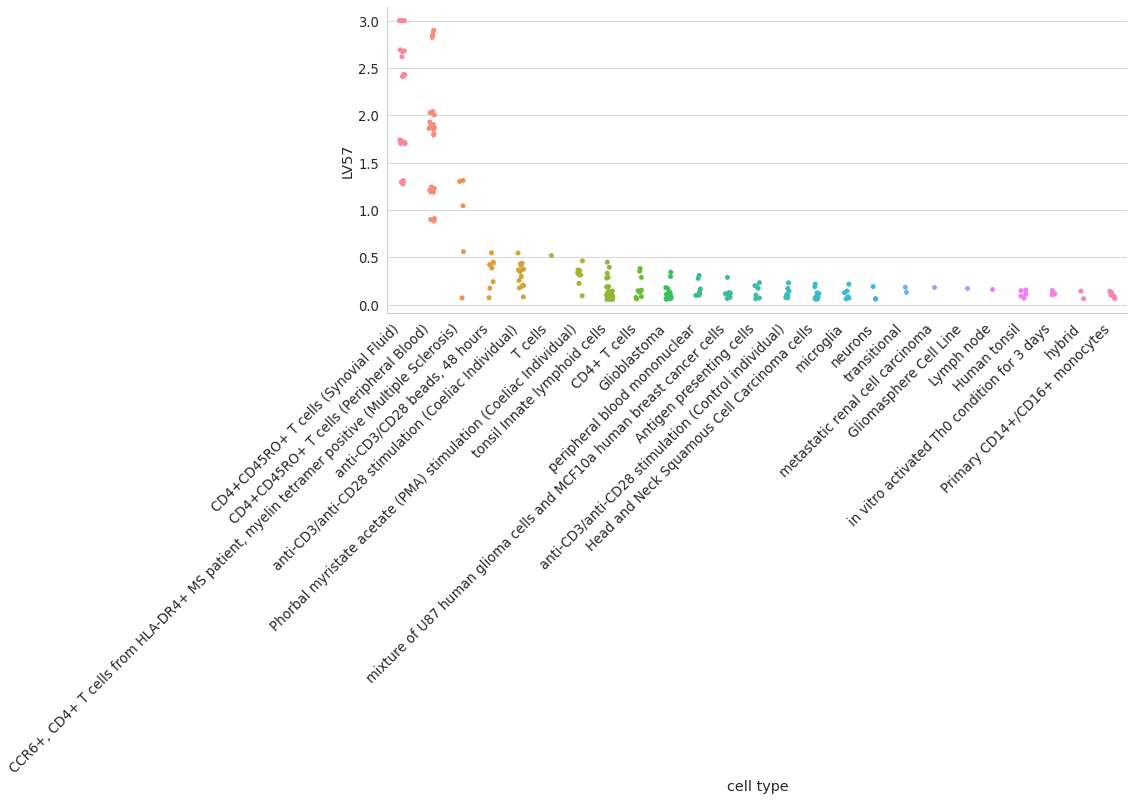

In [42]:
with sns.plotting_context("paper", font_scale=1.5), sns.axes_style("whitegrid"):
    sns.catplot(
        data=final_plot_data,
        y=LV_NAME,
        x=SELECTED_ATTRIBUTE,
        order=attr_order,
        kind="strip",
        height=5,
        aspect=3,
    )
    plt.xticks(rotation=45, horizontalalignment="right")

    plt.savefig(
        OUTPUT_CELL_TYPE_FILEPATH,
        bbox_inches="tight",
        facecolor="white",
    )

# Debug

In [43]:
# with pd.option_context(
#     "display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None
# ):
#     _tmp = final_plot_data[final_plot_data[SELECTED_ATTRIBUTE].str.contains("NOT CAT")]
#     display(_tmp.head(20))

In [44]:
# # what is there in these projects?
# lv_data.loc[["SRP050499"]].dropna(how="all", axis=1).sort_values(
#     LV_NAME, ascending=False
# ).head(60)